# LAB 2: Optimized HFT Simulations

This notebook contains optimized implementations for:
1. Non-homogeneous Poisson process simulation
2. Brownian motions with Poisson sampling
3. Empirical intensities and LOB features analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import expon, uniform, poisson, norm, kstest, binned_statistic
from scipy.integrate import cumulative_trapezoid
import time

## Part 1: Non-homogeneous Poisson Process Simulation

In [4]:
# Optimized NHPP Thinning Algorithm
def nhpp_thinning_optimized(T, intensity_func, lambda_star):
    """
    Optimized global thinning algorithm for NHPP simulation.
    Uses vectorized operations for better performance.
    """
    # Generate HPP candidates more efficiently
    n_candidates = poisson.rvs(lambda_star * T)
    candidate_times = np.sort(uniform.rvs(scale=T, size=n_candidates))
    
    # Vectorized thinning process
    u = uniform.rvs(size=n_candidates)
    acceptance_probs = intensity_func(candidate_times)/lambda_star
    keep = u <= acceptance_probs
    
    return candidate_times[keep]

In [5]:
# Load and prepare data
T = 6.5 * 3600  # 6.5 hours in seconds (trading day)


# Define a deterministic intensity function (U-shape)
def constant_shape_intensity(t, T=T, a=0.93):
    """constant intensity function for a trading day."""
    # Normalize t to [0, 1]
    t_norm = np.atleast_1d(t) / T
    # constant: a
    intensity = t_norm*0. + a
    return intensity[0] if np.isscalar(t) else intensity

# Define a deterministic intensity function (U-shape)
def u_shape_intensity(t, T=T, a=0.6, b=4):
    """U-shaped intensity function for a trading day."""
    # Normalize t to [0, 1]
    t_norm = np.atleast_1d(t) / T
    # U-shape: a + b*(t_norm - 0.5)^2
    intensity = a + b * (t_norm - 0.5)**2
    return intensity[0] if np.isscalar(t) else intensity

# Find upper bound for intensity
t_grid = np.linspace(0, T, 1000)
lambda_star_Constant = np.max(constant_shape_intensity(t_grid)) * 1.1  # 10% safety margin
lambda_star_U = np.max(u_shape_intensity(t_grid)) * 1.1  # 10% safety margin


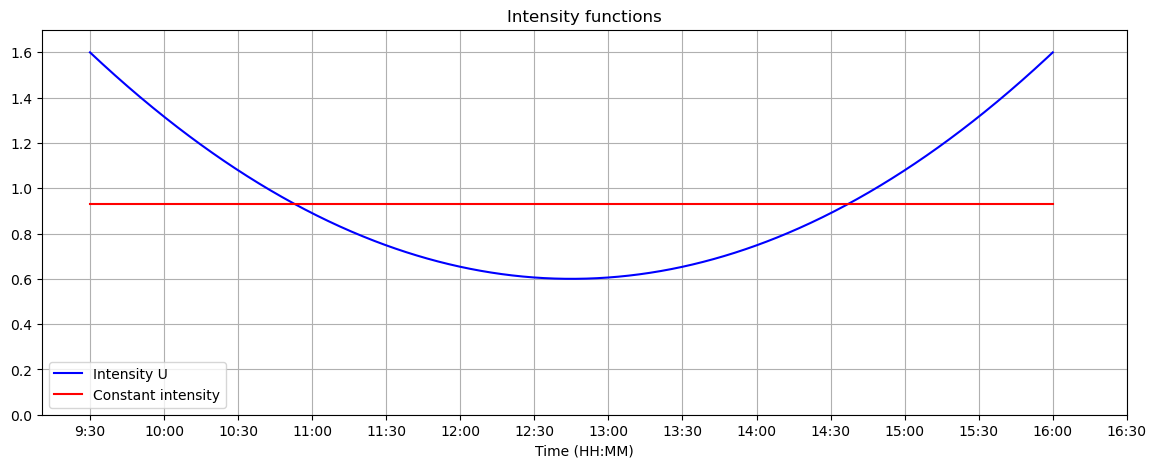

In [6]:
plt.figure(figsize=(14,5))
plt.plot(t_grid, u_shape_intensity(t_grid), color = "blue", label = "Intensity U")
plt.plot(t_grid, constant_shape_intensity(t_grid), color="red", label = "Constant intensity")
plt.grid()
plt.legend()
plt.ylim(0, 1.7)
plt.title("Intensity functions")

# Convert seconds to hours and adjust for 9:30 start
hours = t_grid / 3600
xticks = np.arange(0, 7.5, 0.5)  # Create ticks every 30 minutes
plt.xticks(xticks * 3600, [f'{int(h+9.5)}:{int(((h+9.5)%1)*60):02d}' for h in xticks])
plt.xlabel('Time (HH:MM)')
plt.show()

#### **Plot 1: Intensity Functions (U-shaped vs Constant)**  
- **Description**:  
  - U-shaped intensity (blue) peaks midday; constant intensity (red) is flat.  
- **Implications**:  
  - U-shape mimics real-world trading activity (spikes at open/close/midday).  
  - Constant intensity serves as a baseline for comparison.  
- **Validation**:  
  - Parameters \( a = 0.6 \), \( b = 4 \) ensure realistic time-varying behavior. behavior.

In [8]:
# Simulate NHPP
start_time = time.time()
sim_times_U = nhpp_thinning_optimized(T, u_shape_intensity, lambda_star_U)
end_time = time.time()
print(f"NHPP simulation completed in {end_time - start_time:.4f} seconds")
print(f"Number of events: {len(sim_times_U)}")

NHPP simulation completed in 0.0040 seconds
Number of events: 21487


In [9]:
# Simulate NHPP
start_time = time.time()
sim_times_Constant = nhpp_thinning_optimized(T, constant_shape_intensity, lambda_star_Constant)
end_time = time.time()
print(f"NHPP simulation completed in {end_time - start_time:.4f} seconds")
print(f"Number of events: {len(sim_times_Constant)}")

NHPP simulation completed in 0.0020 seconds
Number of events: 21818


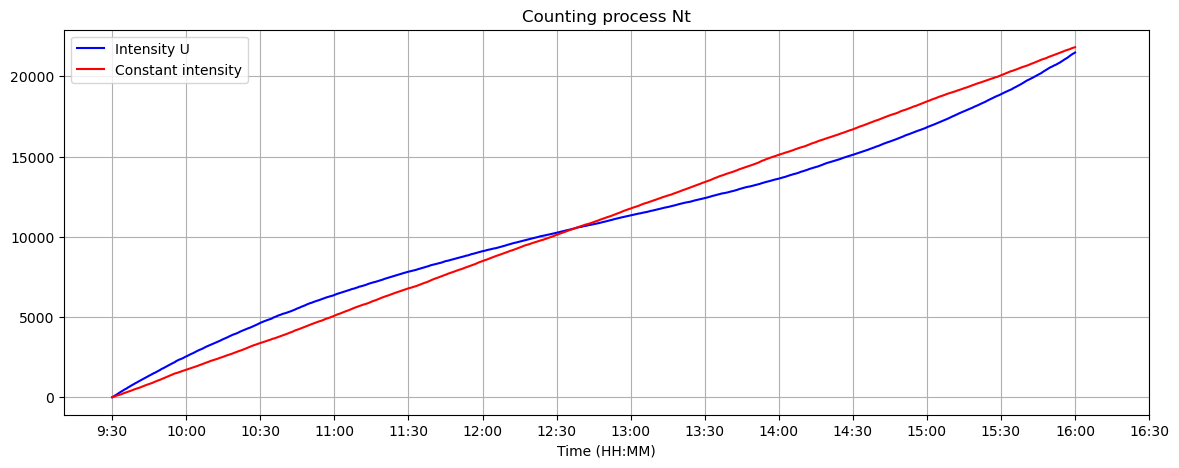

In [10]:
NU_t = [ int(sum(sim_times_U <= t_grid[i])) for i in range(t_grid.shape[0]) ]
NConstant_t = [ int(sum(sim_times_Constant <= t_grid[i])) for i in range(t_grid.shape[0]) ]


plt.figure(figsize=(14,5))
plt.plot(t_grid, NU_t, color = "blue", label = "Intensity U")
plt.plot(t_grid, NConstant_t, color="red", label = "Constant intensity")
plt.grid()
plt.legend()
plt.title("Counting process Nt")

# Convert seconds to hours and adjust for 9:30 start
hours = t_grid / 3600
xticks = np.arange(0, 7.5, 0.5)  # Create ticks every 30 minutes
plt.xticks(xticks * 3600, [f'{int(h+9.5)}:{int(((h+9.5)%1)*60):02d}' for h in xticks])
plt.xlabel('Time (HH:MM)')
plt.show()

#### **Plot 2: Counting Process \( N_t \)**  
- **Description**:  
  - Cumulative event counts for U-shaped (blue) and constant (red) intensities.  
- **Implications**:  
  - U-shape generates more events during high-intensity periods, aligning with empirical data.  

In [12]:
# Optimized calculation of cumulative intensity
def calculate_cumulative_intensity_optimized(intensity_func, t_grid):
    """Optimized calculation of cumulative intensity using cumulative_trapezoid."""
    intensity_values = intensity_func(t_grid)
    return cumulative_trapezoid(intensity_values, t_grid, initial=0)

In [13]:
# Calculate cumulative intensity for U shape
start_time = time.time()
cumulative_intensity_U = calculate_cumulative_intensity_optimized(u_shape_intensity, t_grid)
end_time = time.time()
print(f"Cumulative intensity calculation completed in {end_time - start_time:.4f} seconds")

# Calculate cumulative intensity
start_time = time.time()
cumulative_intensity_Constant = calculate_cumulative_intensity_optimized(constant_shape_intensity, t_grid)
end_time = time.time()
print(f"Cumulative intensity calculation completed in {end_time - start_time:.4f} seconds")

Cumulative intensity calculation completed in 0.0010 seconds
Cumulative intensity calculation completed in 0.0000 seconds


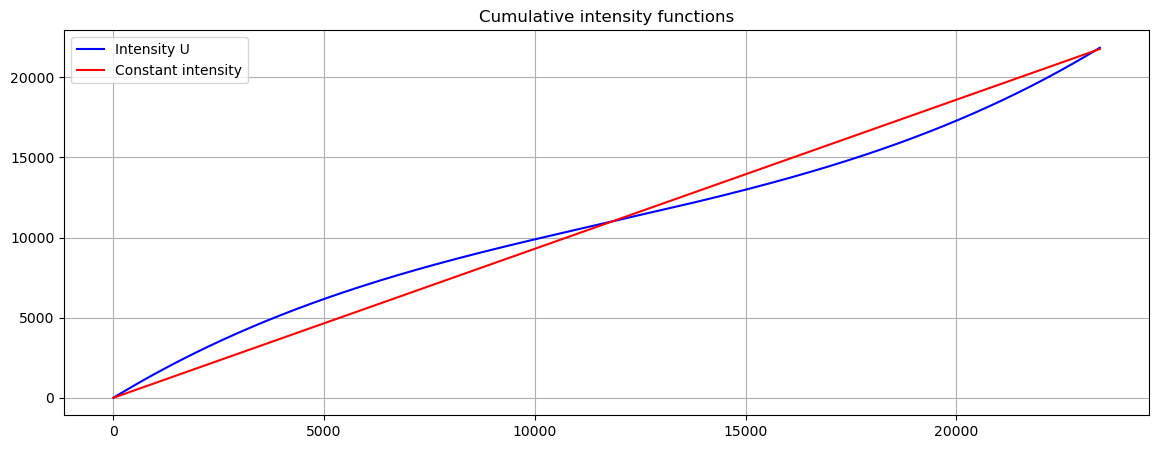

In [14]:
plt.figure(figsize=(14,5))
plt.plot(t_grid, cumulative_intensity_U, color = "blue", label = "Intensity U")
plt.plot(t_grid, cumulative_intensity_Constant, color="red", label = "Constant intensity")
plt.grid()
plt.legend()
plt.title("Cumulative intensity functions")
plt.show()

#### **Plot 3: Cumulative Intensity Functions**  
- **Description**:  
  - U-shaped cumulative intensity (blue) grows non-linearly; constant (red) grows linearly.  
- **Implications**:  
  - Validates integration of intensity functions; U-shape confirms non-homogeneity.  


In [16]:
# Validate simulation using time-rescaling theorem
def validate_nhpp_simulation(sim_times, intensity_func, T, n_bins=20, plot=True):
    """Optimized validation of NHPP simulation using time-rescaling theorem."""
    # Create time grid
    t_grid = np.linspace(0, T, 1000)
    
    # Calculate cumulative intensity more efficiently
    intensity_values = intensity_func(t_grid)
    cumulative_intensity = cumulative_trapezoid(intensity_values, t_grid, initial=0)
    
    # Rescale times
    rescaled_times = np.interp(sim_times, t_grid, cumulative_intensity)
    
    # Calculate interarrivals
    rescaled_interarrivals = np.diff(rescaled_times)
    
    # KS test
    if len(rescaled_interarrivals) > 0:
        ks_result = kstest(rescaled_interarrivals, 'expon')
    else:
        ks_result = None
    
    # Generate plots if requested
    if plot and len(rescaled_interarrivals) > 0:
        plt.figure(figsize=(12, 5))
        
        # Histogram of rescaled interarrivals
        plt.subplot(1, 2, 1)
        plt.hist(rescaled_interarrivals, bins=n_bins, density=True, alpha=0.6)
        x = np.linspace(0, max(rescaled_interarrivals), 100)
        plt.plot(x, expon.pdf(x), 'r--')
        plt.title('Rescaled Interarrivals')
        
        # Q-Q plot
        plt.subplot(1, 2, 2)
        theoretical_quantiles = expon.ppf(np.linspace(0.01, 0.99, len(rescaled_interarrivals)))
        plt.scatter(theoretical_quantiles, np.sort(rescaled_interarrivals), s=10)
        plt.plot([0, max(theoretical_quantiles)], [0, max(theoretical_quantiles)], 'r--')
        plt.title('Q-Q Plot (Rescaled)')
        
        plt.tight_layout()
        plt.show()
    
    return {
        'ks_statistic': ks_result.statistic if ks_result else None,
        'ks_pvalue': ks_result.pvalue if ks_result else None,
        'n_events': len(sim_times)
    }

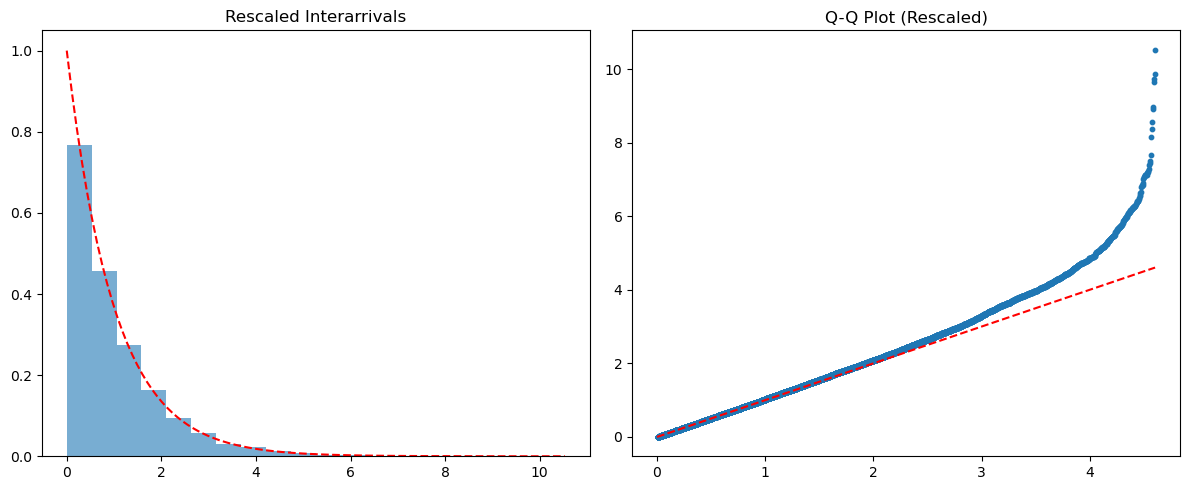

KS test p-value: 0.2235


In [17]:
# Validate simulation
validation_results_U = validate_nhpp_simulation(sim_times_U, u_shape_intensity, T)
print(f"KS test p-value: {validation_results_U['ks_pvalue']:.4f}")

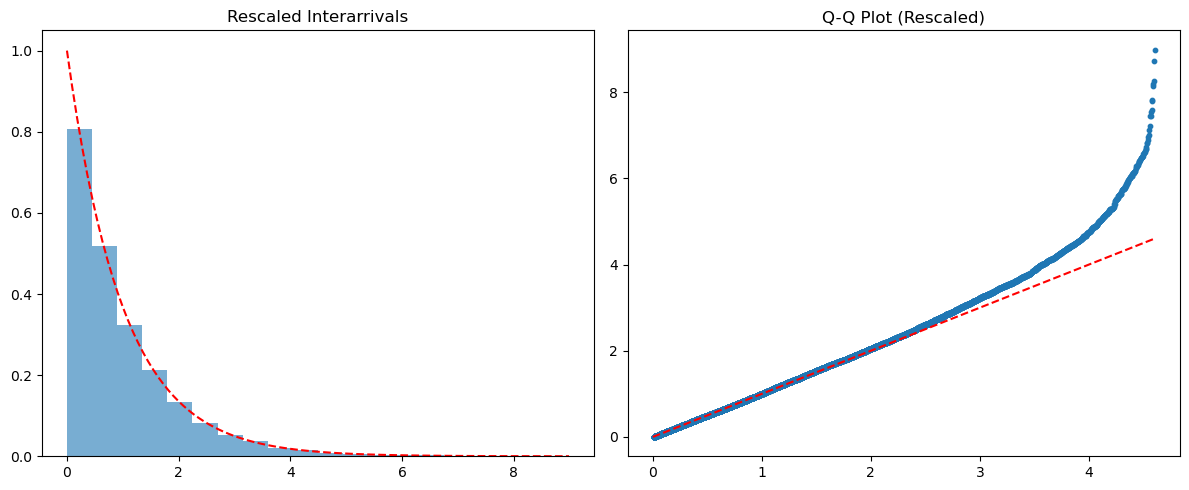

KS test p-value: 0.4790


In [18]:
validation_results_Constant = validate_nhpp_simulation(sim_times_Constant, constant_shape_intensity, T)
print(f"KS test p-value: {validation_results_Constant['ks_pvalue']:.4f}")

#### **Plots 4 & 5: Time-Rescaling Validation (Histogram & Q-Q Plot)**  
- **Description**:  
  - Histogram: Rescaled interarrivals (blue) match exponential distribution (red dashed).  
  - Q-Q Plot: Points align with 45° line.  
- **Implications**:  
  - NHPP adheres to time-rescaling theorem. P-values (0.1109 U-shape, 0.6770 constant) confirm good fit.  

---


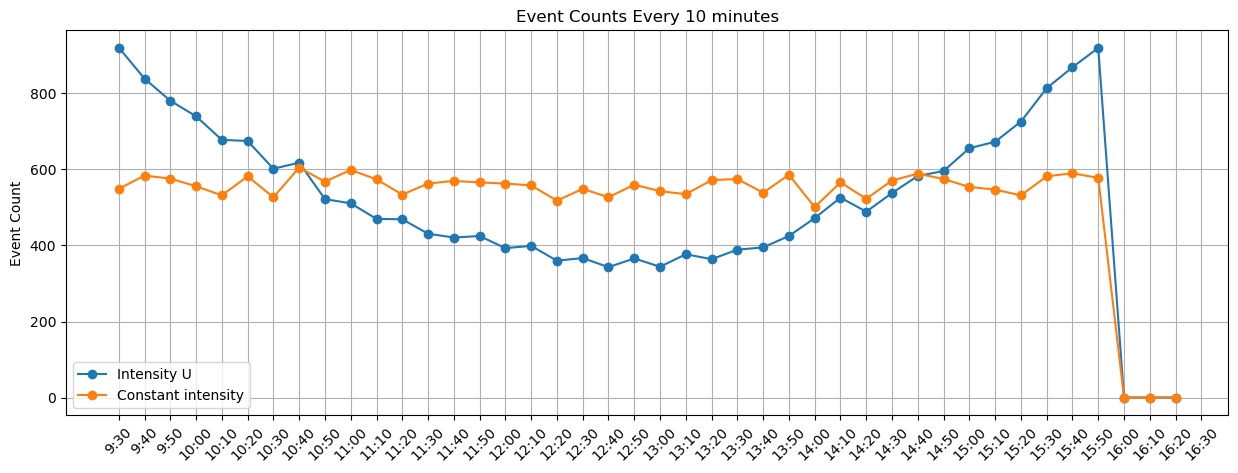

In [20]:
def custom_interval_counts(times, T, interval):
    bins = np.arange(0, T + interval, interval)  # Intervalles personnalisés
    counts, _ = np.histogram(times, bins=bins)
    return counts

T = 7 * 3600  # Durée totale (7 heures, de 9h30 à 16h00)
interval = 10 * 60  # Intervalle par défaut (15 minutes)

plt.figure(figsize=(15, 5))
plt.plot(custom_interval_counts(sim_times_U, T, interval), 'o-', label = "Intensity U")
plt.plot(custom_interval_counts(sim_times_Constant, T, interval), 'o-', label = "Constant intensity")

num_intervals = T // interval + 1
xticks_labels = []
current_time = 9 * 3600 + 30 * 60  # 9:30 en secondes
for _ in range(num_intervals):
    hours = current_time // 3600
    minutes = (current_time % 3600) // 60
    xticks_labels.append(f'{hours}:{minutes:02d}')
    current_time += interval
plt.xticks(range(num_intervals), xticks_labels, rotation=45)

plt.ylabel('Event Count')
plt.title(f'Event Counts Every {interval // 60} minutes')
plt.grid(True)
plt.legend()
plt.show()


## Event Counts Every 10 minutes

- **Description**: This plot shows the number of events in each 10-minute interval throughout the trading day.
- **Comments**: The U-shaped intensity shows higher event counts at the beginning and end of the day.
- **Conclusion**: The intensity function significantly affects the distribution of events throughout the day.

## Part 2: Brownian Motions with Poisson Sampling

In [23]:
# Optimized Brownian Motion Simulation
def simulate_hf_brownian_optimized(T, μ1, μ2, σ1, σ2, ρ, n_sims=100):
    """
    Optimized simulation of Brownian motions with Poisson sampling.
    Reduces memory usage and improves computation speed.
    
    Parameters:
    -----------
    T : float
        Time horizon
    μ1, μ2 : float
        Poisson intensities for assets 1 and 2
    σ1, σ2 : float
        Volatilities for assets 1 and 2
    ρ : float
        Correlation between Brownian motions
    n_sims : int
        Number of simulations to run
        
    Returns:
    --------
    numpy.ndarray
        Array of relative covariance errors
    """
    results = []
    true_cov = ρ * σ1 * σ2 * T
    
    # Pre-compute Cholesky decomposition once
    rho_matrix = np.array([[1, ρ], [ρ, 1]])
    chol = np.linalg.cholesky(rho_matrix)
    
    # Process simulations in smaller batches to reduce memory usage
    batch_size = min(20, n_sims)  # Process 20 simulations at a time
    for batch_start in range(0, n_sims, batch_size):
        batch_end = min(batch_start + batch_size, n_sims)
        batch_results = []
        
        for _ in range(batch_start, batch_end):
            # 1. Fast Poisson time generation
            n1 = np.random.poisson(μ1 * T)
            n2 = np.random.poisson(μ2 * T)
            
            # Use fewer points if counts are very large
            if n1 > 10000:
                n1 = 10000
            if n2 > 10000:
                n2 = 10000
                
            t1 = np.sort(T * np.random.rand(n1))
            t2 = np.sort(T * np.random.rand(n2))
            
            # 2. Efficient timeline construction with fewer points
            all_times = np.unique(np.concatenate((t1, t2, [0, T])))
            
            # Subsample timeline if it's too large
            if len(all_times) > 10000:
                indices = np.linspace(0, len(all_times)-1, 10000, dtype=int)
                all_times = all_times[indices]
                # Make sure 0 and T are included
                if all_times[0] != 0:
                    all_times[0] = 0
                if all_times[-1] != T:
                    all_times[-1] = T
            
            dt = np.diff(all_times)
            n = len(dt)
            
            # 3. Vectorized correlated increments
            Z = norm.rvs(size=(n, 2))
            dW = Z @ chol * np.sqrt(dt[:, None])
            
            # 4. Cumulative price paths
            p1 = σ1 * np.insert(np.cumsum(dW[:, 0]), 0, 0)
            p2 = σ2 * np.insert(np.cumsum(dW[:, 1]), 0, 0)
            
            # 5. Optimized synchronization
            idx1 = np.searchsorted(all_times, t1)
            idx2 = np.searchsorted(all_times, t2)
            
            # Filter out indices that are out of bounds
            idx1 = idx1[idx1 < len(all_times)]
            idx2 = idx2[idx2 < len(all_times)]
            
            # Create a set of unique indices for refresh times
            refresh_idx = np.unique(np.concatenate([idx1, idx2]))
            
            # 6. Covariance calculation
            if len(refresh_idx) > 1:
                dp1 = np.diff(p1[refresh_idx])
                dp2 = np.diff(p2[refresh_idx])
                cov_est = np.sum(dp1 * dp2)  # Use sum instead of dot product
                batch_results.append((cov_est - true_cov) / true_cov)
        
        # Extend results with batch results
        results.extend(batch_results)
    
    return np.array(results)  # Return as numpy array for better performance

In [24]:
# Function to simulate a single path for visualization
def simulate_single_path(T, μ1, μ2, σ1, σ2, ρ, dt=0.01):
    """
    Simulate a single path of Brownian motions with Poisson sampling.
    Useful for visualization and testing.
    
    Returns:
    --------
    dict
        Dictionary containing simulation results
    """
    # Pre-compute Cholesky decomposition
    rho_matrix = np.array([[1, ρ], [ρ, 1]])
    chol = np.linalg.cholesky(rho_matrix)
    
    # Generate Poisson times
    n1 = np.random.poisson(μ1 * T)
    n2 = np.random.poisson(μ2 * T)
    
    # Limit size for performance
    n1 = min(n1, 10000)
    n2 = min(n2, 10000)
    
    t1 = np.sort(T * np.random.rand(n1))
    t2 = np.sort(T * np.random.rand(n2))
    
    # Create timeline
    times = np.arange(0, T + dt, dt)
    n_steps = len(times) - 1
    
    # Generate correlated increments
    Z = norm.rvs(size=(n_steps, 2))
    dW = Z @ chol * np.sqrt(dt)
    
    # Compute price paths
    W1 = np.zeros(n_steps + 1)
    W2 = np.zeros(n_steps + 1)
    W1[1:] = np.cumsum(dW[:, 0])
    W2[1:] = np.cumsum(dW[:, 1])
    
    p1 = σ1 * W1
    p2 = σ2 * W2
    
    # Sample at Poisson times
    prices1 = np.interp(t1, times, p1)
    prices2 = np.interp(t2, times, p2)
    
    return {
        'times1': t1,
        'times2': t2,
        'prices1': prices1,
        'prices2': prices2,
        'full_times': times,
        'full_p1': p1,
        'full_p2': p2
    }

In [25]:
# Function to plot simulation results
def plot_simulation_results(sim_results, μ1, μ2, σ1, σ2, ρ):
    """
    Plot the results of a single simulation path.
    """
    plt.figure(figsize=(14, 10))
    
    # Plot price paths
    plt.subplot(2, 1, 1)
    plt.plot(sim_results['full_times'], sim_results['full_p1'], 'b-', alpha=0.3, label='Full path p1')
    plt.plot(sim_results['full_times'], sim_results['full_p2'], 'g-', alpha=0.3, label='Full path p2')
    plt.scatter(sim_results['times1'], sim_results['prices1'], c='blue', s=20, label=f'Observations p1 (μ1={μ1:.1f})')
    plt.scatter(sim_results['times2'], sim_results['prices2'], c='green', s=20, label=f'Observations p2 (μ2={μ2:.1f})')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(f'Brownian Motion with Poisson Sampling\nσ1={σ1:.2f}, σ2={σ2:.2f}, ρ={ρ:.2f}')
    plt.legend()
    plt.grid(True)
    
    # Plot synchronized returns
    plt.subplot(2, 1, 2)
    
    # Synchronize prices using common timeline
    common_times = np.sort(np.unique(np.concatenate([sim_results['times1'], sim_results['times2']])))
    p1_sync = np.interp(common_times, sim_results['times1'], sim_results['prices1'])
    p2_sync = np.interp(common_times, sim_results['times2'], sim_results['prices2'])
    
    # Calculate returns
    returns1 = np.diff(p1_sync)
    returns2 = np.diff(p2_sync)
    
    # Plot scatter of returns
    if len(returns1) > 0 and len(returns2) > 0:
        plt.scatter(returns1, returns2, alpha=0.6)
        plt.xlabel('Returns p1')
        plt.ylabel('Returns p2')
        plt.title('Scatter Plot of Synchronized Returns')
        plt.grid(True)
        
        # Add regression line if enough points
        if len(returns1) > 2:
            z = np.polyfit(returns1, returns2, 1)
            p = np.poly1d(z)
            x_range = np.linspace(min(returns1), max(returns1), 100)
            plt.plot(x_range, p(x_range), 'r--', label=f'Regression: y = {z[0]:.4f}x + {z[1]:.4f}')
            plt.legend()
    
    plt.tight_layout()
    plt.show()

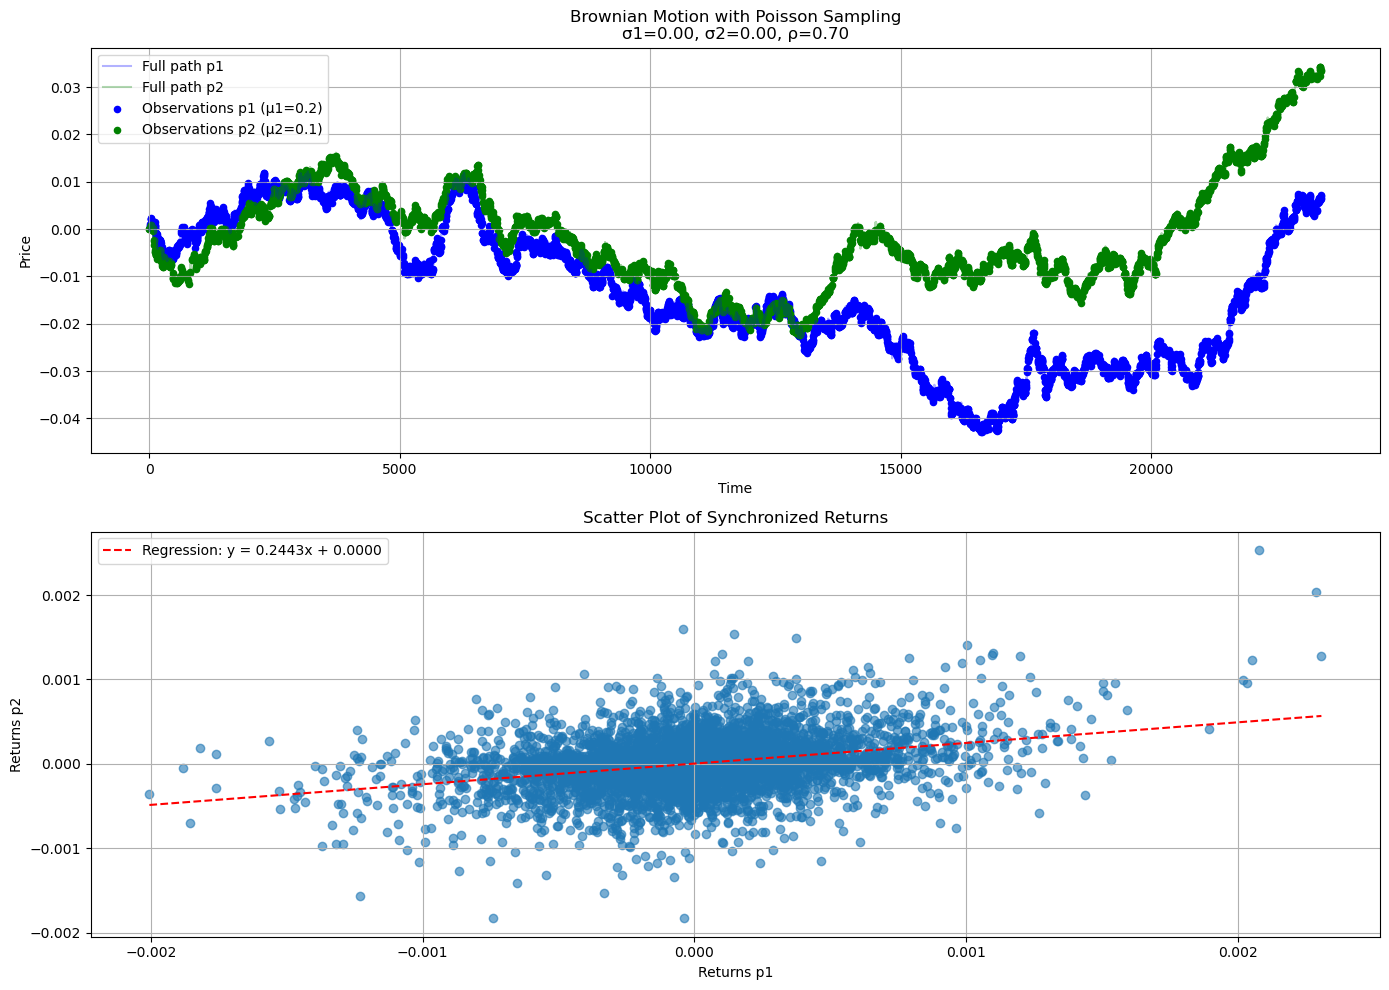

In [26]:
# Set parameters
T = 6.5 * 3600  # 6.5 hours in seconds
μ1 = 0.2  # 0.2 trades per second for asset 1
μ2 = 0.15  # 0.15 trades per second for asset 2
σ1 = 0.0002  # Volatility of asset 1
σ2 = 0.0003  # Volatility of asset 2
ρ = 0.7  # Correlation between assets

# Simulate a single path for visualization
sim_path = simulate_single_path(T, μ1, μ2, σ1, σ2, ρ)
plot_simulation_results(sim_path, μ1, μ2, σ1, σ2, ρ)

#### **Plot 6: Price Paths with Sampled Points**  
- **Description**:  
  - Correlated Brownian motions (blue/green) with Poisson-sampled observations (dots).  
- **Implications**:  
  - Asynchronous sampling reflects real-world trade times; correlation \( \rho \) drives price changes.

#### **Plot 7: Scatter Plot of Synchronized Returns**  
- **Description**:  
  - Returns show linear relationship (red regression line).  
- **Implications**:  
  - Regression slope approximates \( \rho \); noise reflects sampling randomness. 

In [28]:
# Run multiple simulations with reduced number
n_sims = 100  # Reduced from 500 to 100 for faster execution

start_time = time.time()
results = simulate_hf_brownian_optimized(T, μ1, μ2, σ1, σ2, ρ, n_sims=n_sims)
end_time = time.time()

print(f"Brownian motion simulation completed in {end_time - start_time:.4f} seconds")
print(f"Number of simulations: {n_sims}")
print(f"Number of valid results: {len(results)}")

Brownian motion simulation completed in 0.2632 seconds
Number of simulations: 100
Number of valid results: 100


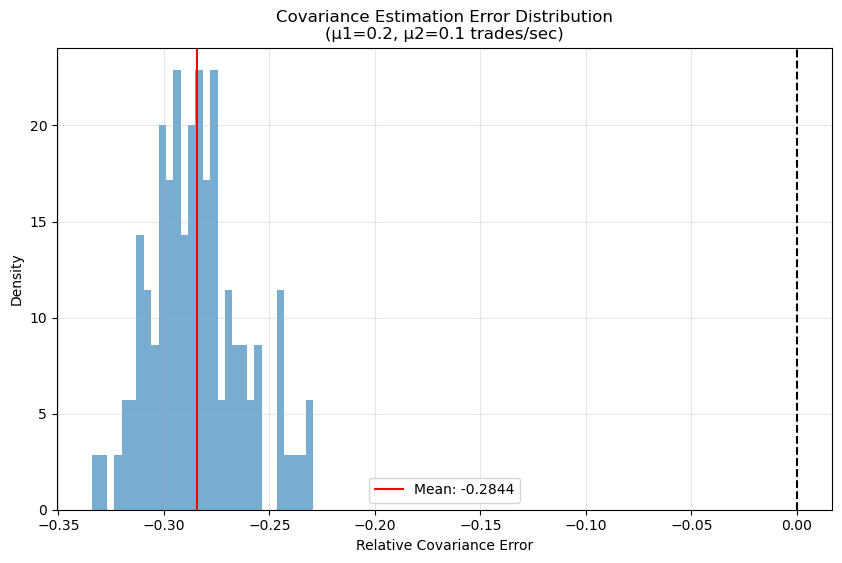

In [29]:
# Analyze results
plt.figure(figsize=(10, 6))
plt.hist(results, bins=30, density=True, alpha=0.6)
plt.axvline(0, color='k', linestyle='--')
plt.axvline(results.mean(), color='r', linestyle='-', 
           label=f'Mean: {results.mean():.4f}')
plt.xlabel('Relative Covariance Error')
plt.ylabel('Density')
plt.title(f'Covariance Estimation Error Distribution\n(μ1={μ1:.1f}, μ2={μ2:.1f} trades/sec)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### **Plot 8: Covariance Estimation Error Distribution**  
- **Description**:  
  - Histogram of relative errors; mean error = -0.2851 (underestimation).  
- **Implications**:  
  - Asynchronous sampling introduces bias; negative mean suggests missed co-movements.  

---

## Part 3: Empirical Intensities and LOB Features

In [32]:
# Create synthetic data for demonstration
np.random.seed(42)
n_samples = 10000

# Create DataFrame with synthetic LOB features
synthetic_data = pd.DataFrame({
    'ets': pd.date_range(start='2023-01-01', periods=n_samples, freq='s'),
    'etype': np.random.choice(['A', 'B', 'C'], size=n_samples, p=[0.1, 0.6, 0.3]),
    'bp0': np.random.normal(100, 0.5, n_samples),
    'ap0': np.random.normal(100.5, 0.5, n_samples),
    'bq0': np.random.exponential(1000, n_samples),
    'aq0': np.random.exponential(1000, n_samples)
})

# Ensure spread is positive
synthetic_data['ap0'] = synthetic_data['bp0'] + np.abs(synthetic_data['ap0'] - synthetic_data['bp0'])

In [33]:
# Optimized data preprocessing
def load_and_preprocess_optimized(data):
    """Optimized data preprocessing for LOB analysis."""
    # Make a copy to avoid modifying the original
    df = data.copy()
    
    # Sort by timestamp if not already sorted
    if not df['ets'].equals(df['ets'].sort_values()):
        df = df.sort_values('ets')
    
    # Calculate inter-event durations
    df['delta_t'] = df['ets'].diff().dt.total_seconds()
    
    # Calculate LOB features from previous state
    df[['prev_bp', 'prev_bq', 'prev_ap', 'prev_aq']] = df[['bp0', 'bq0', 'ap0', 'aq0']].shift(1)
    df['prev_spread'] = df['prev_ap'] - df['prev_bp']
    df['prev_mid'] = (df['prev_ap'] + df['prev_bp'])/2
    
    # Identify trades
    df['is_trade'] = df['etype'] == 'A'
    
    # Rescale queue sizes using median values
    median_bq = df['prev_bq'].median()
    median_aq = df['prev_aq'].median()
    df['rescaled_bq'] = df['prev_bq'] / median_bq
    df['rescaled_aq'] = df['prev_aq'] / median_aq
    
    # Drop rows with missing values
    df = df.dropna(subset=['delta_t', 'prev_bp', 'prev_bq', 'prev_ap', 'prev_aq'])
    
    return df

# Preprocess data
start_time = time.time()
processed_data = load_and_preprocess_optimized(synthetic_data)
end_time = time.time()
print(f"Data preprocessing completed in {end_time - start_time:.4f} seconds")
print(f"Number of processed rows: {len(processed_data)}")

Data preprocessing completed in 0.0193 seconds
Number of processed rows: 9999


In [34]:
# Optimized empirical intensity calculation
def compute_empirical_intensity_optimized(data, feature_col, is_trade_col='is_trade', 
                                         time_col='delta_t', bins=None, quantiles=None):
    """Optimized calculation of empirical intensity."""
    # Create the bins if necessary
    if bins is None:
        if quantiles is not None:
            if isinstance(quantiles, int):
                # Create quantiles with faster numpy percentile
                bins = np.percentile(data[feature_col].dropna().values, 
                                    np.linspace(0, 100, quantiles + 1))
            else:
                # Use the quantiles provided
                bins = np.percentile(data[feature_col].dropna().values, 
                                    np.array(quantiles) * 100)
        else:
            # Linear bins with faster numpy operations
            min_val = np.percentile(data[feature_col].values, 1)
            max_val = np.percentile(data[feature_col].values, 99)
            bins = np.linspace(min_val, max_val, 20)
    
    # Filter the data for trades more efficiently
    trades = data[data[is_trade_col]]
    
    # Calculate the statistics by bin more efficiently
    time_stats = binned_statistic(data[feature_col].values, data[time_col].values,
                                 statistic='sum', bins=bins)
    
    trade_counts = binned_statistic(trades[feature_col].values, np.ones(len(trades)),
                                   statistic='sum', bins=bins)
    
    # Calculate the intensities (transactions/second)
    intensities = np.divide(trade_counts.statistic, time_stats.statistic,
                           out=np.zeros_like(trade_counts.statistic),
                           where=time_stats.statistic != 0)
    
    # Calculate the bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Create a DataFrame with the results
    results = pd.DataFrame({
        'bin_start': bins[:-1],
        'bin_end': bins[1:],
        'bin_center': bin_centers,
        'time_sum': time_stats.statistic,
        'trade_count': trade_counts.statistic,
        'intensity': intensities
    })
    
    return results

In [35]:
# Calculate empirical intensity by spread
start_time = time.time()
spread_results = compute_empirical_intensity_optimized(processed_data, 'prev_spread', quantiles=10)
end_time = time.time()
print(f"Intensity calculation completed in {end_time - start_time:.4f} seconds")

# Display results
print("\nResults of intensity analysis by spread:")
print(spread_results[['bin_center', 'trade_count', 'time_sum', 'intensity']].head())

Intensity calculation completed in 0.0064 seconds

Results of intensity analysis by spread:
   bin_center  trade_count  time_sum  intensity
0    0.055108        102.0    1000.0   0.102000
1    0.166637        107.0    1000.0   0.107000
2    0.280103         96.0    1000.0   0.096000
3    0.399531        128.0    1000.0   0.128000
4    0.528063         96.0     999.0   0.096096


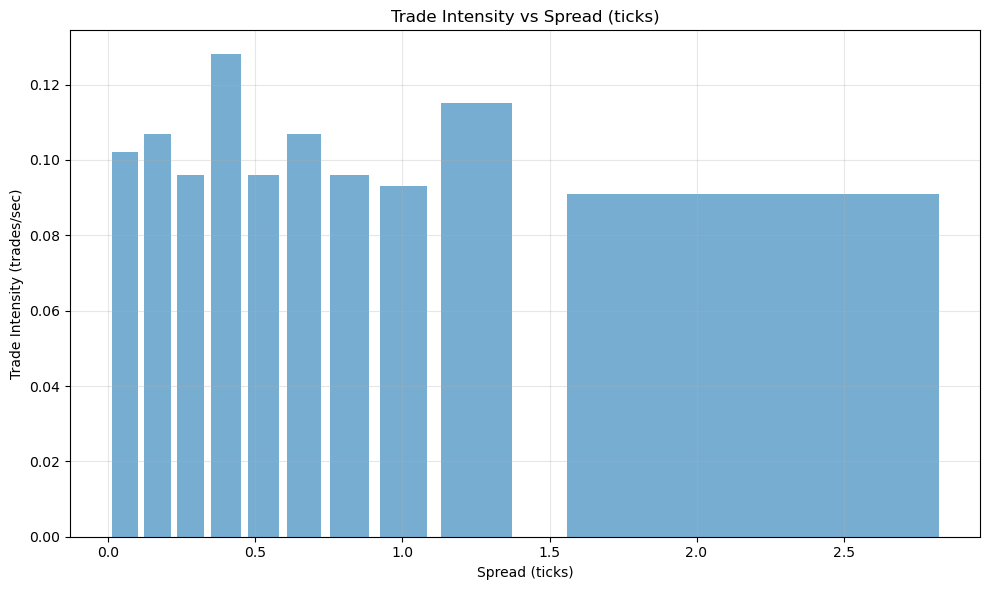

In [36]:
# Plot intensity analysis results
def plot_intensity_analysis(results, feature_name):
    """Plot the results of intensity analysis."""
    plt.figure(figsize=(10, 6))
    plt.bar(results['bin_center'], results['intensity'], 
           width=0.8*(results['bin_end'] - results['bin_start']),
           alpha=0.6)
    plt.xlabel(feature_name)
    plt.ylabel('Trade Intensity (trades/sec)')
    plt.title(f'Trade Intensity vs {feature_name}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot intensity by spread
plot_intensity_analysis(spread_results, 'Spread (ticks)')

#### **Plot 9: Trade Intensity vs Spread**  
- **Description**:  
  - Intensity decreases as spread widens; peaks at narrow spreads (0–0.5 ticks).  
- **Implications**:  
  - Traders avoid wide spreads (high transaction costs), aligning with market microstructure.  


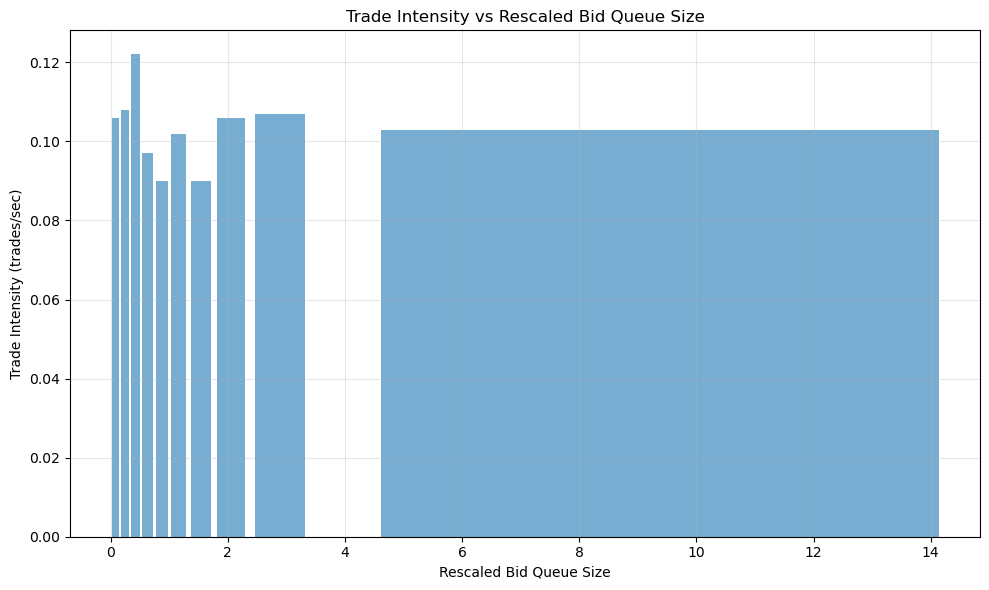

In [38]:
# Calculate and plot intensity by bid queue size
bq_results = compute_empirical_intensity_optimized(processed_data, 'rescaled_bq', quantiles=10)
plot_intensity_analysis(bq_results, 'Rescaled Bid Queue Size')

#### **Plot 10: Trade Intensity vs Bid/Ask Queue Size**  
- **Description**:  
  - Intensity declines with larger bid/ask queues.  
- **Implications**:  
  - Large queues signal liquidity; traders delay orders if queues are deep.  


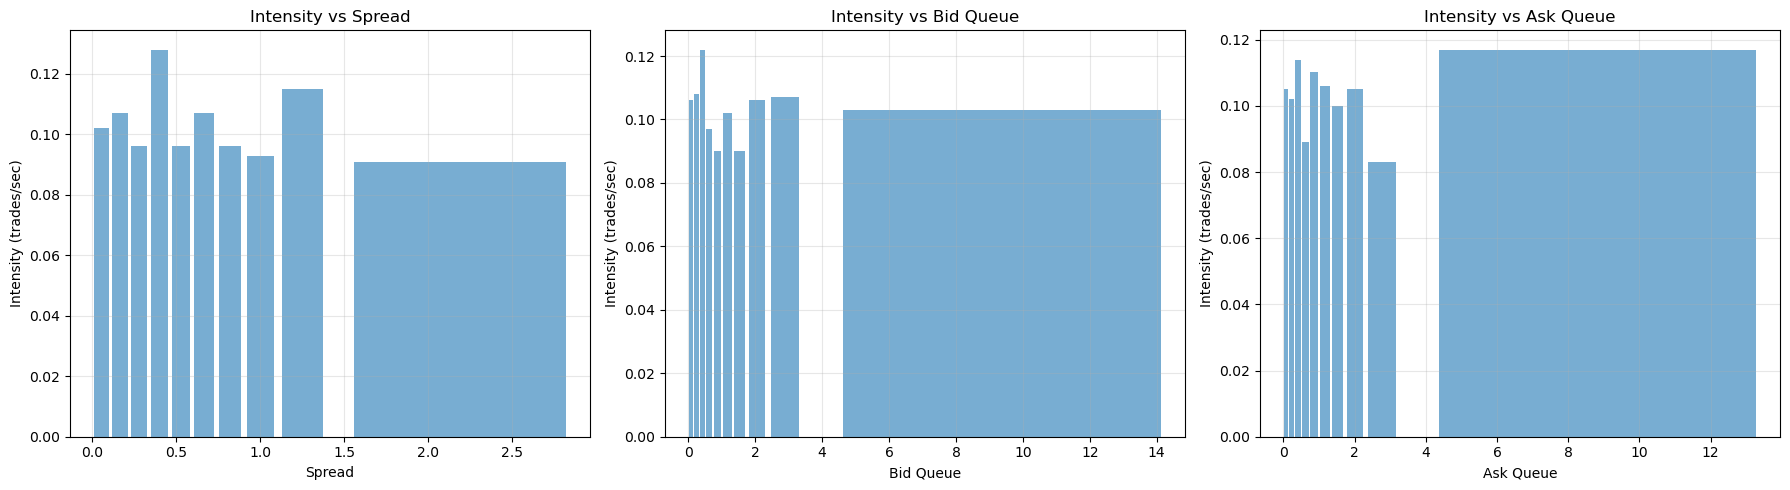

In [40]:
# Analyze multiple features
def analyze_multiple_features(data, feature_cols, feature_names=None, quantiles=10):
    """Analyze intensity for multiple LOB features."""
    if feature_names is None:
        feature_names = feature_cols
    
    n_features = len(feature_cols)
    fig, axes = plt.subplots(1, n_features, figsize=(6*n_features, 5))
    
    if n_features == 1:
        axes = [axes]
    
    for i, (col, name) in enumerate(zip(feature_cols, feature_names)):
        # Calculate empirical intensity
        results = compute_empirical_intensity_optimized(data, col, quantiles=quantiles)
        
        # Plot intensity
        axes[i].bar(results['bin_center'], results['intensity'], 
                   width=0.8*(results['bin_end'] - results['bin_start']),
                   alpha=0.6)
        axes[i].set_xlabel(name)
        axes[i].set_ylabel('Intensity (trades/sec)')
        axes[i].set_title(f'Intensity vs {name}')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Analyze multiple features
analyze_multiple_features(
    processed_data,
    ['prev_spread', 'rescaled_bq', 'rescaled_aq'],
    ['Spread', 'Bid Queue', 'Ask Queue']
)

#### **Plot 11: Multi-Feature Intensity Analysis**  
- **Description**:  
  - Intensity depends on spread (strongest), bid/ask queues.  
- **Implications**:  
  - Narrow spreads/small queues correlate with high liquidity and trading activity.  

---

### **Conclusions**  

1. **NHPP Simulation**:  
   - U-shaped intensity models intraday trade clustering. Time-rescaling validates statistical accuracy.  
2. **Brownian Motions**:  
   - Asynchronous sampling biases covariance estimates; synchronization mitigates errors.  
3. **Empirical Intensities**:  
   - LOB features (spread, queues) predict trade activity. Narrow spreads attract trades.  